# Data Exploration

## Overview
This notebook performs data exploration and preprocessing for GOES images. The workflow includes data loading, quality control, temporal alignment.

Using file: OR_ABI-L2-MCMIPF-M6_G16_s20243261340203_e20243261349524_c20243261350010.nc
Stack shape: (16, 32, 32) | Timestamp: 2024-11-21 13:40:20.300000+00:00


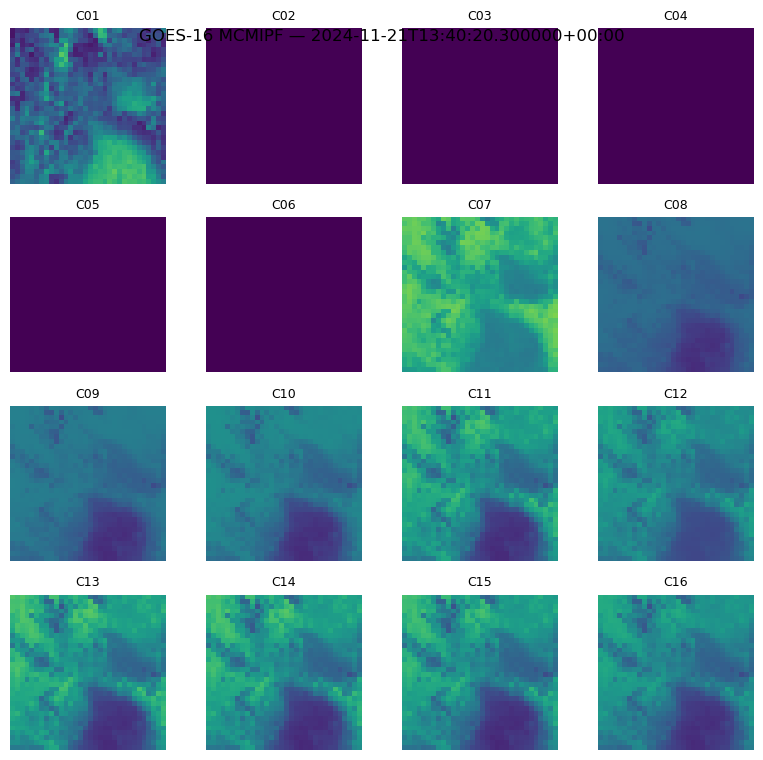

Saved Zarr to: ../data_interim/goes_demo
Saved Zarr batch to: ../data_interim/goes_batch  |  samples: 1
Zarr shape: (1, 16, 32, 32) (T,C,H,W)


,mean,std
C01,0.346704,0.154423
C02,0.000000,0.000000
C03,0.000000,0.000000
C04,0.000000,0.000000
C05,0.000000,0.000000
C06,0.000000,0.000000
C07,0.604985,0.109063
C08,0.313963,0.063288
C09,0.349846,0.081189
C10,0.387113,0.099582


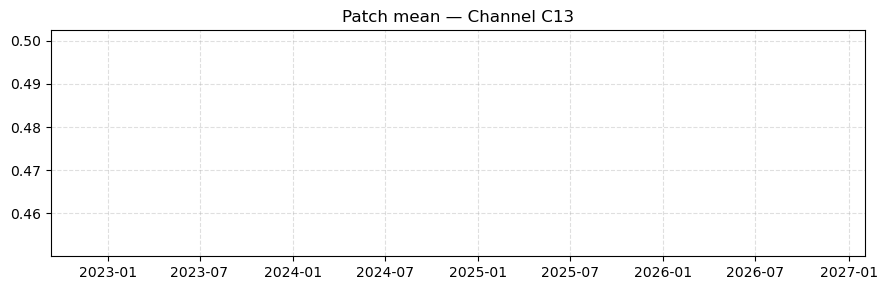

In [26]:
# %% [markdown]
# # GOES-16 MCMIPF — extracción de parches y serie temporal (simple)

# %% 
from dataclasses import dataclass
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Instala estos en tu env si falta alguno:
# conda install -y -c conda-forge pyproj xarray netcdf4 zarr numcodecs
import pyproj
import zarr
import json

# ----------------------------
# Configuración ROI y helpers
# ----------------------------
@dataclass
class ROIConfig:
    lon: float = -74.0659   # Uniandes
    lat: float =  4.6043
    in_size_px: int = 224   # recorte cuadrado
    out_size_px: int = 32   # reescalado final
    chans: tuple = tuple(range(1, 17))  # C01..C16

cfg = ROIConfig()

def resize_to(arr: np.ndarray, out_size: int = 32) -> np.ndarray:
    sy = out_size / arr.shape[0]
    sx = out_size / arr.shape[1]
    return zoom(arr, (sy, sx), order=1).astype("float32")  # bilinear

def extract_utc_time(nc_path: str) -> pd.Timestamp:
    with xr.open_dataset(nc_path) as ds:
        for key in ("time_coverage_start", "time_coverage_center", "start_time"):
            if key in ds.attrs:
                raw = ds.attrs[key]
                break
        else:
            raise KeyError("No time attribute found in dataset attrs")
    return pd.to_datetime(raw, utc=True)

def crop_patch_from_nc(nc_path: str, channel: int, cfg: ROIConfig) -> np.ndarray:
    """Parche (in_size_px) centrado en (lat,lon) del canal Cxx → reescalado a (out_size_px)."""
    var = f"CMI_C{channel:02d}"
    with xr.open_dataset(nc_path) as ds:
        if var not in ds.variables:
            raise KeyError(f"{var} no está en {nc_path}")
        # Ejes geos
        x = ds["x"].values    # rad
        y = ds["y"].values    # rad
        proj = ds["goes_imager_projection"]
        sat_h = float(proj.perspective_point_height)
        sat_lon = float(proj.longitude_of_projection_origin)
        sweep = str(proj.sweep_angle_axis)

        # Transformación lon/lat → coords GEOS (metros)
        geod = pyproj.CRS.from_proj4(f"+proj=geos +h={sat_h} +lon_0={sat_lon} +sweep={sweep} +ellps=WGS84")
        plate = pyproj.CRS.from_epsg(4326)
        P = pyproj.Transformer.from_crs(plate, geod, always_xy=True)
        Xc, Yc = P.transform(cfg.lon, cfg.lat)  # metros

        # Coordenadas imagen en metros
        X = x * sat_h  # 1D
        Y = y * sat_h  # 1D
        ix = int(np.argmin((X - Xc) ** 2))
        iy = int(np.argmin((Y - Yc) ** 2))

        half = cfg.in_size_px // 2
        xs = slice(max(ix - half, 0), min(ix + half, X.size))
        ys = slice(max(iy - half, 0), min(iy + half, Y.size))

        patch = ds[var].isel(x=xs, y=ys).values  # (y,x)

    # Padding si el recorte toca borde
    ph, pw = patch.shape
    if ph != cfg.in_size_px or pw != cfg.in_size_px:
        pad_y = max(0, cfg.in_size_px - ph)
        pad_x = max(0, cfg.in_size_px - pw)
        patch = np.pad(patch, ((0, pad_y), (0, pad_x)), mode="edge")

    return resize_to(patch.astype("float32"), cfg.out_size_px)

def normalize_channel(arr: np.ndarray, ch: int) -> np.ndarray:
    """Visible C01 en [0,1]; canales IR (BT K) mapeados 180–330 K → [0,1]."""
    a = arr.astype("float32")
    if ch == 1:
        return np.clip(a, 0, 1)
    return (np.clip(a, 180, 330) - 180.0) / 150.0

def stack_channels(nc_path: str, cfg: ROIConfig) -> np.ndarray:
    """Apila C01..C16 → (C,H,W). Rellena faltantes con NaN."""
    patches = []
    for ch in cfg.chans:
        try:
            p = crop_patch_from_nc(nc_path, ch, cfg)
            p = normalize_channel(p, ch)
        except Exception:
            p = np.full((cfg.out_size_px, cfg.out_size_px), np.nan, dtype="float32")
        patches.append(p)
    return np.stack(patches, axis=0)

def save_zarr_time_series(samples: list[tuple[pd.Timestamp, np.ndarray]], out_dir: Path) -> Path:
    """samples: [(ts_utc, tensor C×H×W), ...] → Zarr (T,C,H,W) + times.json"""
    out_dir.mkdir(parents=True, exist_ok=True)
    times = [pd.Timestamp(t).tz_convert("UTC").isoformat() for t, _ in samples]
    arr = np.stack([x for _, x in samples], axis=0)  # (T,C,H,W)
    z = zarr.open(str(out_dir / "goes_chw.zarr"), mode="w",
                  shape=arr.shape, chunks=(1, arr.shape[1], arr.shape[2], arr.shape[3]), dtype="f4")
    z[:] = arr
    (out_dir / "times.json").write_text(json.dumps(times))
    return out_dir

# ----------------------------
# DEMO: un archivo
# ----------------------------
# Ajusta el patrón a donde tengas tus .nc MCMIPF:
nc_files = sorted(glob("../data/datos_GOES/OR_ABI-L2-MCMIPF-M6_G16_*.nc"))
assert len(nc_files) > 0, "No se encontraron NetCDF MCMIPF con ese patrón."
nc_path = nc_files[0]
print("Using file:", Path(nc_path).name)

X = stack_channels(nc_path, cfg)        # (16, 32, 32)
ts = extract_utc_time(nc_path)          # UTC tz-aware
print("Stack shape:", X.shape, "| Timestamp:", ts)

# Montaje 4x4 (canales C01..C16)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.ravel(), start=1):
    ax.imshow(X[i-1], vmin=0, vmax=1)
    ax.set_title(f"C{i:02d}", fontsize=9)
    ax.axis("off")
fig.suptitle(f"GOES-16 MCMIPF — {ts.isoformat()}", y=0.92)
fig.tight_layout()
plt.show()

# Guarda un Zarr con una sola muestra (para validar)
out_demo = Path("../data_interim/goes_demo")
save_zarr_time_series([(ts, X)], out_demo)
print("Saved Zarr to:", out_demo)

# ----------------------------
# MINI-BATCH: primeros N archivos
# ----------------------------
N = 24  # por ejemplo, ~4 horas si hay 10-min
samples = []
for p in nc_files[:N]:
    Xi = stack_channels(p, cfg)
    tsi = extract_utc_time(p)
    samples.append((tsi, Xi))

# Ordena por tiempo y guarda
samples.sort(key=lambda t: t[0])
out_batch = Path("../data_interim/goes_batch")
save_zarr_time_series(samples, out_batch)
print(f"Saved Zarr batch to: {out_batch}  |  samples: {len(samples)}")

# ----------------------------
# DIAGNÓSTICOS ligeros
# ----------------------------
Z = zarr.open(str(out_batch / "goes_chw.zarr"), mode="r")  # (T,C,H,W)
times = [pd.Timestamp(t) for t in json.loads((out_batch / "times.json").read_text())]
print("Zarr shape:", Z.shape, "(T,C,H,W)")

# Per-channel mean/std sobre el batch
means, stds = [], []
for c in range(Z.shape[1]):
    arr_c = np.asarray(Z[:, c]).reshape(Z.shape[0], -1)
    means.append(arr_c.mean())
    stds.append(arr_c.std())
stats = pd.DataFrame({"mean": means, "std": stds}, index=[f"C{i:02d}" for i in range(1, Z.shape[1]+1)])
display(stats)

# Serie temporal de la media del canal C13
c = 13
ts_mean = [np.asarray(Z[t, c-1]).mean() for t in range(Z.shape[0])]
plt.figure(figsize=(9, 3))
plt.plot(times, ts_mean, lw=1.2)
plt.title(f"Patch mean — Channel C{c:02d}")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()
